In [2]:
# Cell 1: Environment & imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
import math
import glob
import json

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Cell 2: Set up data directory
# Update this path to where your CMAPSS data files are located
# NOTE: training file 'train_FD002.txt' in your workspace is at
#       c:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\train_FD002.txt
# Adjust DATA_DIR to the parent folder so joins below locate the file correctly.
DATA_DIR = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI'

# Check if files exist
train_file = os.path.join(DATA_DIR, 'train_FD002.txt')
test_file = os.path.join(DATA_DIR, 'test_FD002.txt')
rul_file = os.path.join(DATA_DIR, 'RUL_FD002.txt')

print(f"Train file exists: {os.path.exists(train_file)}")
print(f"Test file exists: {os.path.exists(test_file)}")
print(f"RUL file exists: {os.path.exists(rul_file)}")

Train file exists: False
Test file exists: False
RUL file exists: False


In [4]:
# Cell 3: Function to read CMAPSS text files (whitespace separated, no header)
def read_cmapss(filepath):
    """
    Read CMAPSS format: 26 columns whitespace separated
    columns: unit, cycle, op_setting_1..3, sensor_1..21
    """
    col_names = (["unit", "cycle",
                  "op_setting_1", "op_setting_2", "op_setting_3"] +
                 [f"s{i}" for i in range(1, 22)])
    df = pd.read_csv(filepath, sep=r"\s+", header=None, names=col_names)
    return df

# Read training data
df_train = read_cmapss(train_file)
print(f"Training data shape: {df_train.shape}")
print(f"Columns: {list(df_train.columns)}")
print(f"\nFirst few rows:")
print(df_train.head())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Sneha\\OneDrive\\Desktop\\AI-PrognosAI\\train_FD002.txt'

In [ ]:
# Cell 4: Create RUL (Remaining Useful Life) labels for training data
def add_rul_train(df):
    """
    For each unit, RUL = max_cycle_for_unit - current_cycle
    """
    df = df.copy()
    max_cycle = df.groupby("unit")["cycle"].max().reset_index()
    max_cycle.columns = ["unit", "max_cycle"]
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    df.drop("max_cycle", axis=1, inplace=True)
    return df

# Add RUL to training data
df_train = add_rul_train(df_train)
print(f"Training data with RUL shape: {df_train.shape}")
print(f"RUL statistics:")
print(df_train["RUL"].describe())
print(f"\nNumber of unique units: {df_train['unit'].nunique()}")

Training data with RUL shape: (53759, 27)
RUL statistics:
count    53759.000000
mean       108.154746
std         69.180569
min          0.000000
25%         51.000000
50%        103.000000
75%        156.000000
max        377.000000
Name: RUL, dtype: float64

Number of unique units: 260


In [ ]:
# Cell 5: Data preprocessing - normalize sensors and cap RUL
def preprocess_df(df, cap_rul=125, scaler=None, fit_scaler=True):
    """
    Normalize sensor and operational setting columns.
    Cap RUL at a maximum value.
    """
    df = df.copy()
    
    # Auto-detect sensor and operational setting columns
    sensor_cols = [c for c in df.columns if c.startswith('s') or c.startswith('op_setting')]
    
    # Cap RUL
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)
    
    # Fit scaler if not provided
    if scaler is None and fit_scaler:
        scaler = StandardScaler()
        scaler.fit(df[sensor_cols])
    
    # Apply scaling
    if scaler is not None:
        df[sensor_cols] = scaler.transform(df[sensor_cols])
    
    return df, scaler, sensor_cols

# Apply preprocessing
df_train_pre, scaler, sensor_cols = preprocess_df(df_train, cap_rul=125)
print(f"Sensor columns ({len(sensor_cols)}): {sensor_cols}")
print(f"Preprocessed data shape: {df_train_pre.shape}")
print(f"RUL_capped statistics:")
print(df_train_pre["RUL_capped"].describe())

Sensor columns (24): ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Preprocessed data shape: (53759, 28)
RUL_capped statistics:
count    53759.000000
mean        86.913354
std         41.665602
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL_capped, dtype: float64


In [ ]:
# Cell 6: Create sequences for GRU model
def generate_sequences(df, seq_len=50, sensor_cols=None, label_col="RUL_capped", step=1):
    """
    Create sliding windows of sequences for each unit.
    Each sequence predicts RUL at the last timestep.
    """
    Xs = []
    ys = []
    units = sorted(df["unit"].unique())
    
    for u in units:
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp[label_col].values
        n_cycles = data.shape[0]
        
        # Skip units with fewer cycles than sequence length
        if n_cycles < seq_len:
            continue
        
        # Create sliding windows
        for start in range(0, n_cycles - seq_len + 1, step):
            end = start + seq_len
            Xs.append(data[start:end])
            ys.append(labels[end - 1])
    
    X = np.array(Xs)
    y = np.array(ys)
    return X, y

# Generate sequences
SEQ_LEN = 50
X, y = generate_sequences(df_train_pre, seq_len=SEQ_LEN, sensor_cols=sensor_cols)
print(f"Sequences generated:")
print(f"X shape: {X.shape} (samples, sequence_length, features)")
print(f"y shape: {y.shape}")
print(f"y statistics: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

Sequences generated:
X shape: (41019, 50, 24) (samples, sequence_length, features)
y shape: (41019,)
y statistics: min=0.00, max=125.00, mean=75.45


In [ ]:
# Cell 7: Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)
print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")

Train set: X=(34866, 50, 24), y=(34866,)
Validation set: X=(6153, 50, 24), y=(6153,)


In [ ]:
# Cell 8: Build GRU model
def build_gru_model(input_shape, units=64, dropout=0.2):
    """Build a GRU-based neural network for RUL prediction."""
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_gru_model((SEQ_LEN, len(sensor_cols)), units=128, dropout=0.3)
print("Model created successfully!")
model.summary()

c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Cell 9: Train the model
EPOCHS = 60
BATCH_SIZE = 128

checkpoint_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5'
scaler_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\scaler_fd002.joblib'

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Model saved to: {checkpoint_path}")
print(f"Scaler saved to: {scaler_path}")

Starting training...
Epoch 1/60
Epoch 1/60

Epoch 1: val_loss improved from inf to 819.60883, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 1: val_loss improved from inf to 819.60883, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 30s - 111ms/step - loss: 2221.6248 - mae: 36.1158 - val_loss: 819.6088 - val_mae: 23.4397
Epoch 2/60
Epoch 2/60

Epoch 2: val_loss improved from 819.60883 to 514.64825, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 2: val_loss improved from 819.60883 to 514.64825, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 23s - 83ms/step - loss: 626.6148 - mae: 20.0407 - val_loss: 514.6483 - val_mae: 18.2088
Epoch 3/60
Epoch 3/60

Epoch 3: val_loss improved from 514.64825 to 440.23987, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 3: val_loss improved from 514.64825 to 440.23987, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 23s - 83ms/step - loss: 540.5719 - mae: 18.4423 - val_loss: 440.2399 - val_mae: 16.6581
Epoch 4/60
Epoch 4/60

Epoch 4: val_loss improved from 440.23987 to 374.67593, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 4: val_loss improved from 440.23987 to 374.67593, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 79ms/step - loss: 460.1926 - mae: 16.8493 - val_loss: 374.6759 - val_mae: 15.2691
Epoch 5/60
Epoch 5/60

Epoch 5: val_loss improved from 374.67593 to 258.21484, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 5: val_loss improved from 374.67593 to 258.21484, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 80ms/step - loss: 359.5517 - mae: 14.7224 - val_loss: 258.2148 - val_mae: 12.4124
Epoch 6/60
Epoch 6/60

Epoch 6: val_loss improved from 258.21484 to 221.00096, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 6: val_loss improved from 258.21484 to 221.00096, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 82ms/step - loss: 325.2807 - mae: 13.9700 - val_loss: 221.0010 - val_mae: 11.4286
Epoch 7/60
Epoch 7/60

Epoch 7: val_loss improved from 221.00096 to 218.78232, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 7: val_loss improved from 221.00096 to 218.78232, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 23s - 84ms/step - loss: 279.4481 - mae: 12.9095 - val_loss: 218.7823 - val_mae: 11.4860
Epoch 8/60
Epoch 8/60

Epoch 8: val_loss improved from 218.78232 to 199.33130, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 8: val_loss improved from 218.78232 to 199.33130, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 81ms/step - loss: 260.1089 - mae: 12.4231 - val_loss: 199.3313 - val_mae: 10.9967
Epoch 9/60
Epoch 9/60

Epoch 9: val_loss did not improve from 199.33130
273/273 - 21s - 78ms/step - loss: 231.0208 - mae: 11.7035 - val_loss: 215.8078 - val_mae: 11.1538
Epoch 10/60

Epoch 9: val_loss did not improve from 199.33130
273/273 - 21s - 78ms/step - loss: 231.0208 - mae: 11.7035 - val_loss: 215.8078 - val_mae: 11.1538
Epoch 10/60

Epoch 10: val_loss improved from 199.33130 to 173.71169, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 10: val_loss improved from 199.33130 to 173.71169, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 23s - 84ms/step - loss: 215.0021 - mae: 11.3357 - val_loss: 173.7117 - val_mae: 10.1236
Epoch 11/60
Epoch 11/60

Epoch 11: val_loss did not improve from 173.71169
273/273 - 22s - 80ms/step - loss: 193.5695 - mae: 10.7506 - val_loss: 251.2747 - val_mae: 12.2598
Epoch 12/60

Epoch 11: val_loss did not improve from 173.71169
273/273 - 22s - 80ms/step - loss: 193.5695 - mae: 10.7506 - val_loss: 251.2747 - val_mae: 12.2598
Epoch 12/60

Epoch 12: val_loss improved from 173.71169 to 126.03986, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 12: val_loss improved from 173.71169 to 126.03986, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 80ms/step - loss: 180.7063 - mae: 10.3883 - val_loss: 126.0399 - val_mae: 8.4935
Epoch 13/60
Epoch 13/60

Epoch 13: val_loss did not improve from 126.03986
273/273 - 22s - 81ms/step - loss: 163.9212 - mae: 9.9347 - val_loss: 218.3788 - val_mae: 11.5612
Epoch 14/60

Epoch 13: val_loss did not improve from 126.03986
273/273 - 22s - 81ms/step - loss: 163.9212 - mae: 9.9347 - val_loss: 218.3788 - val_mae: 11.5612
Epoch 14/60

Epoch 14: val_loss improved from 126.03986 to 90.41006, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 14: val_loss improved from 126.03986 to 90.41006, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 27s - 99ms/step - loss: 153.4421 - mae: 9.6285 - val_loss: 90.4101 - val_mae: 7.4012
Epoch 15/60
Epoch 15/60

Epoch 15: val_loss improved from 90.41006 to 77.38503, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 15: val_loss improved from 90.41006 to 77.38503, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 40s - 145ms/step - loss: 139.5453 - mae: 9.1731 - val_loss: 77.3850 - val_mae: 6.7172
Epoch 16/60
Epoch 16/60

Epoch 16: val_loss improved from 77.38503 to 74.38439, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 16: val_loss improved from 77.38503 to 74.38439, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 79ms/step - loss: 127.5066 - mae: 8.7584 - val_loss: 74.3844 - val_mae: 6.5920
Epoch 17/60
Epoch 17/60

Epoch 17: val_loss did not improve from 74.38439
273/273 - 22s - 79ms/step - loss: 118.9166 - mae: 8.4577 - val_loss: 109.9883 - val_mae: 7.9468
Epoch 18/60

Epoch 17: val_loss did not improve from 74.38439
273/273 - 22s - 79ms/step - loss: 118.9166 - mae: 8.4577 - val_loss: 109.9883 - val_mae: 7.9468
Epoch 18/60

Epoch 18: val_loss improved from 74.38439 to 58.42135, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 18: val_loss improved from 74.38439 to 58.42135, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 23s - 83ms/step - loss: 114.8166 - mae: 8.3108 - val_loss: 58.4213 - val_mae: 5.8154
Epoch 19/60
Epoch 19/60

Epoch 19: val_loss did not improve from 58.42135
273/273 - 23s - 85ms/step - loss: 104.9861 - mae: 7.9349 - val_loss: 61.1755 - val_mae: 6.0551
Epoch 20/60

Epoch 19: val_loss did not improve from 58.42135
273/273 - 23s - 85ms/step - loss: 104.9861 - mae: 7.9349 - val_loss: 61.1755 - val_mae: 6.0551
Epoch 20/60

Epoch 20: val_loss improved from 58.42135 to 50.27189, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 20: val_loss improved from 58.42135 to 50.27189, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 79ms/step - loss: 100.8492 - mae: 7.7807 - val_loss: 50.2719 - val_mae: 5.4153
Epoch 21/60
Epoch 21/60

Epoch 21: val_loss did not improve from 50.27189
273/273 - 22s - 82ms/step - loss: 95.1031 - mae: 7.5676 - val_loss: 55.0069 - val_mae: 5.6674
Epoch 22/60

Epoch 21: val_loss did not improve from 50.27189
273/273 - 22s - 82ms/step - loss: 95.1031 - mae: 7.5676 - val_loss: 55.0069 - val_mae: 5.6674
Epoch 22/60

Epoch 22: val_loss did not improve from 50.27189
273/273 - 22s - 81ms/step - loss: 89.9548 - mae: 7.3529 - val_loss: 58.5954 - val_mae: 5.8235
Epoch 23/60

Epoch 22: val_loss did not improve from 50.27189
273/273 - 22s - 81ms/step - loss: 89.9548 - mae: 7.3529 - val_loss: 58.5954 - val_mae: 5.8235
Epoch 23/60

Epoch 23: val_loss did not improve from 50.27189
273/273 - 22s - 79ms/step - loss: 87.8065 - mae: 7.2569 - val_loss: 76.3098 - val_mae: 6.9975
Epoch 24/60

Epoch 23: val_loss did not improve from 50.27189
273/273 - 22s - 79ms/step - loss: 87.8065 - mae: 7.

273/273 - 22s - 80ms/step - loss: 82.9353 - mae: 7.0287 - val_loss: 32.8700 - val_mae: 4.4306
Epoch 25/60
Epoch 25/60

Epoch 25: val_loss did not improve from 32.87003
273/273 - 23s - 83ms/step - loss: 82.1874 - mae: 7.0369 - val_loss: 36.6340 - val_mae: 4.6759
Epoch 26/60

Epoch 25: val_loss did not improve from 32.87003
273/273 - 23s - 83ms/step - loss: 82.1874 - mae: 7.0369 - val_loss: 36.6340 - val_mae: 4.6759
Epoch 26/60

Epoch 26: val_loss did not improve from 32.87003
273/273 - 21s - 78ms/step - loss: 78.8720 - mae: 6.8735 - val_loss: 75.1353 - val_mae: 6.9376
Epoch 27/60

Epoch 26: val_loss did not improve from 32.87003
273/273 - 21s - 78ms/step - loss: 78.8720 - mae: 6.8735 - val_loss: 75.1353 - val_mae: 6.9376
Epoch 27/60

Epoch 27: val_loss improved from 32.87003 to 31.95578, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 27: val_loss improved from 32.87003 to 31.95578, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumod

273/273 - 22s - 79ms/step - loss: 77.7759 - mae: 6.8468 - val_loss: 31.9558 - val_mae: 4.3223
Epoch 28/60
Epoch 28/60

Epoch 28: val_loss did not improve from 31.95578
273/273 - 22s - 81ms/step - loss: 75.7412 - mae: 6.7294 - val_loss: 33.3917 - val_mae: 4.4618
Epoch 29/60

Epoch 28: val_loss did not improve from 31.95578
273/273 - 22s - 81ms/step - loss: 75.7412 - mae: 6.7294 - val_loss: 33.3917 - val_mae: 4.4618
Epoch 29/60

Epoch 29: val_loss did not improve from 31.95578
273/273 - 21s - 78ms/step - loss: 73.0820 - mae: 6.6049 - val_loss: 58.6712 - val_mae: 6.0343
Epoch 30/60

Epoch 29: val_loss did not improve from 31.95578
273/273 - 21s - 78ms/step - loss: 73.0820 - mae: 6.6049 - val_loss: 58.6712 - val_mae: 6.0343
Epoch 30/60

Epoch 30: val_loss improved from 31.95578 to 23.39331, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 30: val_loss improved from 31.95578 to 23.39331, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumod

273/273 - 294s - 1s/step - loss: 69.9779 - mae: 6.4628 - val_loss: 23.3933 - val_mae: 3.6875
Epoch 31/60
Epoch 31/60

Epoch 31: val_loss did not improve from 23.39331
273/273 - 22s - 81ms/step - loss: 68.7839 - mae: 6.4012 - val_loss: 32.2034 - val_mae: 4.3648
Epoch 32/60

Epoch 31: val_loss did not improve from 23.39331
273/273 - 22s - 81ms/step - loss: 68.7839 - mae: 6.4012 - val_loss: 32.2034 - val_mae: 4.3648
Epoch 32/60

Epoch 32: val_loss did not improve from 23.39331
273/273 - 21s - 79ms/step - loss: 65.9618 - mae: 6.2834 - val_loss: 41.4038 - val_mae: 5.0049
Epoch 33/60

Epoch 32: val_loss did not improve from 23.39331
273/273 - 21s - 79ms/step - loss: 65.9618 - mae: 6.2834 - val_loss: 41.4038 - val_mae: 5.0049
Epoch 33/60

Epoch 33: val_loss did not improve from 23.39331
273/273 - 21s - 79ms/step - loss: 65.0191 - mae: 6.2575 - val_loss: 34.2415 - val_mae: 4.5345
Epoch 34/60

Epoch 33: val_loss did not improve from 23.39331
273/273 - 21s - 79ms/step - loss: 65.0191 - mae: 6.25

273/273 - 45s - 166ms/step - loss: 60.2873 - mae: 5.9919 - val_loss: 21.9685 - val_mae: 3.5716
Epoch 36/60
Epoch 36/60

Epoch 36: val_loss did not improve from 21.96847
273/273 - 84s - 309ms/step - loss: 58.5984 - mae: 5.9157 - val_loss: 46.7001 - val_mae: 5.4387
Epoch 37/60

Epoch 36: val_loss did not improve from 21.96847
273/273 - 84s - 309ms/step - loss: 58.5984 - mae: 5.9157 - val_loss: 46.7001 - val_mae: 5.4387
Epoch 37/60

Epoch 37: val_loss did not improve from 21.96847
273/273 - 22s - 80ms/step - loss: 56.7411 - mae: 5.8248 - val_loss: 29.2078 - val_mae: 4.2357
Epoch 38/60

Epoch 37: val_loss did not improve from 21.96847
273/273 - 22s - 80ms/step - loss: 56.7411 - mae: 5.8248 - val_loss: 29.2078 - val_mae: 4.2357
Epoch 38/60

Epoch 38: val_loss did not improve from 21.96847
273/273 - 23s - 83ms/step - loss: 54.6583 - mae: 5.7072 - val_loss: 44.4373 - val_mae: 5.3120
Epoch 39/60

Epoch 38: val_loss did not improve from 21.96847
273/273 - 23s - 83ms/step - loss: 54.6583 - mae: 

273/273 - 23s - 86ms/step - loss: 50.6930 - mae: 5.5058 - val_loss: 20.2942 - val_mae: 3.4786
Epoch 44/60
Epoch 44/60

Epoch 44: val_loss improved from 20.29424 to 19.07537, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 44: val_loss improved from 20.29424 to 19.07537, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 82ms/step - loss: 49.6564 - mae: 5.4727 - val_loss: 19.0754 - val_mae: 3.3481
Epoch 45/60
Epoch 45/60

Epoch 45: val_loss did not improve from 19.07537
273/273 - 23s - 83ms/step - loss: 50.9466 - mae: 5.5301 - val_loss: 45.5670 - val_mae: 5.3875
Epoch 46/60

Epoch 45: val_loss did not improve from 19.07537
273/273 - 23s - 83ms/step - loss: 50.9466 - mae: 5.5301 - val_loss: 45.5670 - val_mae: 5.3875
Epoch 46/60

Epoch 46: val_loss improved from 19.07537 to 19.06961, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 46: val_loss improved from 19.07537 to 19.06961, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 24s - 86ms/step - loss: 48.1128 - mae: 5.4024 - val_loss: 19.0696 - val_mae: 3.4387
Epoch 47/60
Epoch 47/60

Epoch 47: val_loss did not improve from 19.06961

Epoch 47: val_loss did not improve from 19.06961
273/273 - 24s - 87ms/step - loss: 47.1512 - mae: 5.3216 - val_loss: 65.9302 - val_mae: 6.9897
Epoch 48/60
273/273 - 24s - 87ms/step - loss: 47.1512 - mae: 5.3216 - val_loss: 65.9302 - val_mae: 6.9897
Epoch 48/60

Epoch 48: val_loss did not improve from 19.06961
273/273 - 23s - 83ms/step - loss: 47.2762 - mae: 5.3239 - val_loss: 20.6123 - val_mae: 3.5104
Epoch 49/60

Epoch 48: val_loss did not improve from 19.06961
273/273 - 23s - 83ms/step - loss: 47.2762 - mae: 5.3239 - val_loss: 20.6123 - val_mae: 3.5104
Epoch 49/60

Epoch 49: val_loss did not improve from 19.06961
273/273 - 23s - 83ms/step - loss: 44.2687 - mae: 5.1582 - val_loss: 30.1042 - val_mae: 4.3113
Epoch 50/60

Epoch 49: val_loss did not improve from 19.06961
273/273 - 23s - 83ms/step - loss: 44.2687 - mae: 5.1

273/273 - 23s - 85ms/step - loss: 44.7605 - mae: 5.1644 - val_loss: 18.0387 - val_mae: 3.3412
Epoch 53/60
Epoch 53/60

Epoch 53: val_loss did not improve from 18.03869
273/273 - 21s - 78ms/step - loss: 42.4528 - mae: 5.0557 - val_loss: 26.2617 - val_mae: 4.2108

Epoch 53: val_loss did not improve from 18.03869
273/273 - 21s - 78ms/step - loss: 42.4528 - mae: 5.0557 - val_loss: 26.2617 - val_mae: 4.2108
Epoch 54/60
Epoch 54/60

Epoch 54: val_loss improved from 18.03869 to 15.93720, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 54: val_loss improved from 18.03869 to 15.93720, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 21s - 79ms/step - loss: 40.8116 - mae: 4.9350 - val_loss: 15.9372 - val_mae: 3.1486
Epoch 55/60
Epoch 55/60

Epoch 55: val_loss did not improve from 15.93720
273/273 - 22s - 79ms/step - loss: 39.7992 - mae: 4.9114 - val_loss: 29.8869 - val_mae: 4.4425
Epoch 56/60

Epoch 55: val_loss did not improve from 15.93720
273/273 - 22s - 79ms/step - loss: 39.7992 - mae: 4.9114 - val_loss: 29.8869 - val_mae: 4.4425
Epoch 56/60

Epoch 56: val_loss did not improve from 15.93720
273/273 - 23s - 85ms/step - loss: 38.3493 - mae: 4.7981 - val_loss: 17.1315 - val_mae: 3.2027

Epoch 56: val_loss did not improve from 15.93720
273/273 - 23s - 85ms/step - loss: 38.3493 - mae: 4.7981 - val_loss: 17.1315 - val_mae: 3.2027
Epoch 57/60
Epoch 57/60

Epoch 57: val_loss did not improve from 15.93720
273/273 - 23s - 84ms/step - loss: 38.8940 - mae: 4.8596 - val_loss: 20.5854 - val_mae: 3.5283
Epoch 58/60

Epoch 57: val_loss did not improve from 15.93720
273/273 - 23s - 84ms/step - loss: 38.8940 - mae: 4.8

273/273 - 20s - 75ms/step - loss: 38.4385 - mae: 4.8218 - val_loss: 12.0768 - val_mae: 2.6528
Epoch 59/60
Epoch 59/60

Epoch 59: val_loss improved from 12.07680 to 10.19401, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5

Epoch 59: val_loss improved from 12.07680 to 10.19401, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5


273/273 - 22s - 80ms/step - loss: 39.2200 - mae: 4.8598 - val_loss: 10.1940 - val_mae: 2.4845
Epoch 60/60
Epoch 60/60

Epoch 60: val_loss did not improve from 10.19401
273/273 - 21s - 78ms/step - loss: 36.4748 - mae: 4.6962 - val_loss: 12.0197 - val_mae: 2.6897

Epoch 60: val_loss did not improve from 10.19401
273/273 - 21s - 78ms/step - loss: 36.4748 - mae: 4.6962 - val_loss: 12.0197 - val_mae: 2.6897
Restoring model weights from the end of the best epoch: 59.
Restoring model weights from the end of the best epoch: 59.
Model saved to: C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5
Scaler saved to: C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\scaler_fd002.joblib
Model saved to: C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd002.h5
Scaler saved to: C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\scaler_fd002.joblib


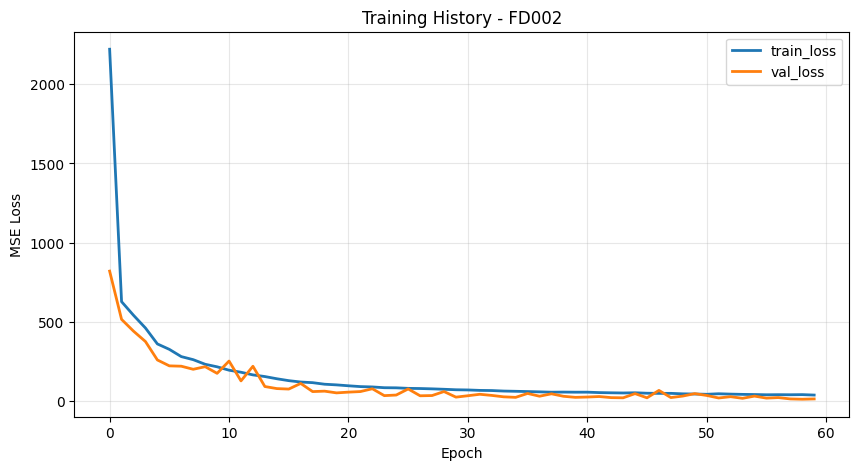

In [ ]:
# Cell 10: Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="train_loss", linewidth=2)
plt.plot(history.history["val_loss"], label="val_loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training History - FD002")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Cell 11: Evaluate on validation set
y_val_pred = model.predict(X_val, verbose=0).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = np.mean(np.abs(y_val - y_val_pred))

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE: {mae_val:.4f}")

Validation RMSE: 3.1928
Validation MAE: 2.4845


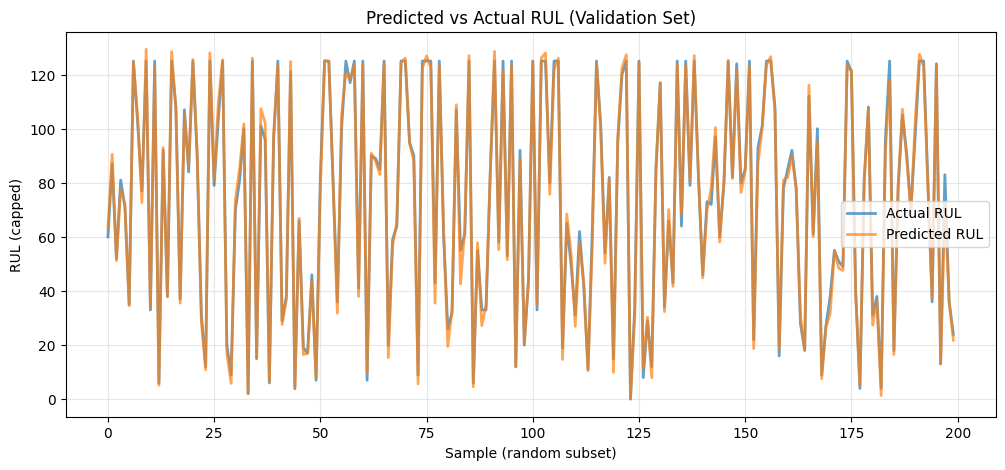

In [ ]:
# Cell 12: Predicted vs Actual plot (random sample)
sample_size = min(200, len(y_val))
idx = np.random.choice(len(y_val), size=sample_size, replace=False)

plt.figure(figsize=(12, 5))
plt.plot(y_val[idx], label="Actual RUL", linewidth=2, alpha=0.7)
plt.plot(y_val_pred[idx], label="Predicted RUL", linewidth=2, alpha=0.7)
plt.xlabel("Sample (random subset)")
plt.ylabel("RUL (capped)")
plt.legend()
plt.title("Predicted vs Actual RUL (Validation Set)")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Cell 13: Test set evaluation (if test files exist)
if os.path.exists(test_file) and os.path.exists(rul_file):
    print("Loading test data...")
    
    # Read test data
    df_test_raw = read_cmapss(test_file)
    
    # Preprocess test data using the fitted scaler
    df_test_scaled = df_test_raw.copy()
    df_test_scaled[sensor_cols] = scaler.transform(df_test_raw[sensor_cols].values)
    
    # Build test sequences: use last SEQ_LEN cycles for each unit
    X_test = []
    test_units = sorted(df_test_scaled["unit"].unique())
    
    for u in test_units:
        tmp = df_test_scaled[df_test_scaled["unit"] == u].sort_values("cycle")
        arr = tmp[sensor_cols].values
        
        if arr.shape[0] >= SEQ_LEN:
            X_test.append(arr[-SEQ_LEN:])
        else:
            # Pad at front if not enough cycles
            pad_n = SEQ_LEN - arr.shape[0]
            pad = np.tile(arr[0], (pad_n, 1))
            X_test.append(np.vstack([pad, arr]))
    
    X_test = np.array(X_test)
    
    # Load true RUL values
    y_test_true = pd.read_csv(rul_file, sep=r"\s+", header=None).values.ravel()
    
    # Cap RUL the same way as training
    CAP_RUL = 125
    y_test_true = np.clip(y_test_true, a_min=None, a_max=CAP_RUL)
    
    # Make predictions
    y_test_pred = model.predict(X_test, verbose=0).ravel()
    
    # Evaluate
    rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test = np.mean(np.abs(y_test_true - y_test_pred))
    
    print(f"\nTest RMSE (capped at {CAP_RUL}): {rmse_test:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test samples: {len(y_test_true)}")
else:
    print("Test files not found!")

Loading test data...


c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Test RMSE (capped at 125): 19.2977
Test MAE: 14.1289
Test samples: 259


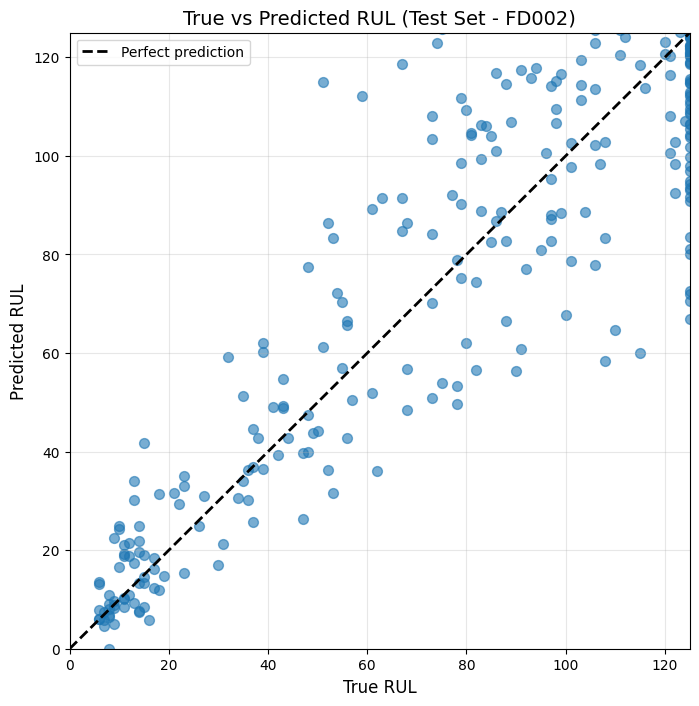

In [ ]:
# Cell 14: Test set scatter plot (True vs Predicted)
if os.path.exists(test_file) and os.path.exists(rul_file):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_true, y_test_pred, alpha=0.6, s=50)
    plt.xlabel("True RUL", fontsize=12)
    plt.ylabel("Predicted RUL", fontsize=12)
    plt.title("True vs Predicted RUL (Test Set - FD002)", fontsize=14)
    plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--", linewidth=2, label="Perfect prediction")
    plt.xlim(0, CAP_RUL)
    plt.ylim(0, CAP_RUL)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Test files not available for visualization")

In [ ]:
# Cell 15: Health status alerts for test units
if os.path.exists(test_file) and os.path.exists(rul_file):
    WARNING_THRESHOLD = 30
    CRITICAL_THRESHOLD = 10
    
    def get_alert_status(rul_value):
        """Determine health status based on RUL prediction."""
        if rul_value <= CRITICAL_THRESHOLD:
            return "CRITICAL ⚠️"
        elif rul_value <= WARNING_THRESHOLD:
            return "WARNING ⚠"
        else:
            return "NORMAL ✓"
    
    print("\n" + "="*80)
    print("HEALTH STATUS ALERTS FOR TEST UNITS (FD002)")
    print("="*80)
    print(f"{'Unit':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Status':<20}")
    print("-"*80)
    
    for i in range(len(test_units)):
        error = abs(y_test_true[i] - y_test_pred[i])
        status = get_alert_status(y_test_pred[i])
        print(f"{test_units[i]:<8} {y_test_true[i]:<12.2f} {y_test_pred[i]:<12.2f} {error:<12.2f} {status:<20}")
    
    print("="*80)
else:
    print("Test files not available for alerts")


HEALTH STATUS ALERTS FOR TEST UNITS (FD002)
Unit     True RUL     Pred RUL     Error        Status              
--------------------------------------------------------------------------------
1        18.00        11.93        6.07         WARNING ⚠           
2        79.00        111.85       32.85        NORMAL ✓            
3        106.00       77.89        28.11        NORMAL ✓            
4        110.00       64.75        45.25        NORMAL ✓            
5        15.00        14.56        0.44         WARNING ⚠           
6        125.00       121.97       3.03         NORMAL ✓            
7        6.00         7.76         1.76         CRITICAL ⚠️         
8        90.00        56.32        33.68        NORMAL ✓            
9        11.00        21.12        10.12        WARNING ⚠           
10       79.00        90.26        11.26        NORMAL ✓            
11       6.00         13.50        7.50         WARNING ⚠           
12       73.00        108.15       35.15      